<a href="https://colab.research.google.com/github/jamespan1118/Xenopus_signal_processing/blob/main/Frog_calling_separation_pipline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##A pipeline to separate a male-female duet recording to different constituent parts

In [ ]:
!pip install librosa
import librosa
from librosa import display
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
import scipy
import csv
import random
from scipy import fftpack
from scipy.ndimage import gaussian_filter1d
from scipy.io.wavfile import write
from scipy.fft import fft, fftfreq, rfft, rfftfreq, irfft

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def clear_out(lower,upper,data,points_per_freq):
  target_idx_noise_lower = int(points_per_freq * lower)
  target_idx_noise_upper = int(points_per_freq * upper)
  data[: target_idx_noise_lower] = 0
  data[target_idx_noise_upper:] = 0
  
def fourier_transform(samples, sampling_rate):
  #fourier transform on audio file
  yf = rfft(samples)
  xf = rfftfreq(len(samples), 1 / sampling_rate)
  return xf,yf

#smooth the curve
def smooth_curve(randomlist_yf,sigma=40):
  #We get a smoother curve upon increasing the value of sigma.
  y_smoothed = gaussian_filter1d(randomlist_yf, sigma)
  peaks, _  = scipy.signal.find_peaks(y_smoothed)
  troughs, _  = scipy.signal.find_peaks(-y_smoothed)
  return peaks,troughs,y_smoothed

def peak_processing(peaks,randomlist_xf):
  #remove all peaks with xf value below 450, between 700 and 1600, and above 2500
  for i in peaks:
    if((randomlist_xf[i]<450) or
      ((randomlist_xf[i]>700) and (randomlist_xf[i]<1600))or
      (randomlist_xf[i]>2500)):
      peaks = np.delete(peaks,np.argwhere(peaks == i))
  peaks_list = randomlist_xf[peaks]
  return peaks_list

def trough_processing(troughs,randomlist_xf):
  #if the smallest trough that's below 450 is below 350  replace it with 350
  if(randomlist_xf[troughs].min()<350):
    troughs_list = np.where(randomlist_xf[troughs]<350,350,randomlist_xf[troughs])
  else:
    troughs_list = np.append([350], randomlist_xf[troughs], axis = 0)
  return troughs_list

def generate_boundaries(peaks_list,troughs_list):
  #getting the boundaries for the female call
  i = 0
  while(troughs_list[i] < peaks_list[0]):
    i+=1
  upper_bound_0 = troughs_list[i]
  lower_bound_0 = troughs_list[i-1]

  #getting the boundaries for the male call
  while(troughs_list[i] < peaks_list[1]):
    i+=1
  upper_bound_1 = troughs_list[i]
  #the lower bound of the male call: take the 
  #difference between the upper bound and the peak,
  #and use the peak value to subtract the difference
  difference = upper_bound_1 - peaks_list[1]
  lower_bound_1 = peaks_list[1] - difference
  #the lower bound of male call can't go below 1500Hz for
  #Xenopus Laevis or Xenopus Petersii
  if(lower_bound_1 < 1500):
    lower_bound_1 = 1500
  boundary_list = [150,lower_bound_0,upper_bound_0,lower_bound_1,3000]
  return boundary_list

def write_audio(samples,lowerlimit,upperlimit,points_per_freq,file_name,specific_name,sampling_rate=44100):
  yf_special = rfft(samples)
  clear_out(lowerlimit,upperlimit,yf_special,points_per_freq)
  new_sig = irfft(yf_special)
  write(file_name+specific_name,sampling_rate,new_sig)

In [ ]:
def male_female_call_separation(file_path,file_name,sampling_rate=44100):
  #load audio file
  samples, sampling_rate = librosa.load(file_path,sr=sampling_rate)

  #perform fourier transform on the data
  xf,yf = fourier_transform(samples, sampling_rate)

  #get the number of points per frequency
  points_per_freq = len(xf) / (sampling_rate / 2)

  #rough clean of data for smoothing
  clear_out(150,3000,yf,points_per_freq)

  #sample down audio file to 23274 data points
  randomlist = random.sample(list(range(0,(len(xf)-1))),23274)
  randomlist.sort()
  randomlist_xf = xf[randomlist]
  randomlist_yf = np.abs(yf)[randomlist]

  peaks,troughs,y_smoothed = smooth_curve(randomlist_yf)

  #data processing on the peaks and troughs
  peaks_list = peak_processing(peaks,randomlist_xf)
  troughs_list = trough_processing(troughs,randomlist_xf)

  boundary_list = generate_boundaries(peaks_list,troughs_list)

  #plot the graph
  
  plt.figure(figsize=(20,5))
  plt.plot(xf,np.abs(yf),color="grey")
  plt.plot(randomlist_xf,y_smoothed,color="red")
  plt.plot(randomlist_xf[peaks],y_smoothed[peaks],"x")
  plt.plot(randomlist_xf[troughs],y_smoothed[troughs],"o",color="green")
  plt.vlines(boundary_list,-10,3000,colors='black', linestyles='dashed')
  ticks = np.concatenate([np.arange(0, 4000, step=1000),boundary_list])
  ticks.sort()
  plt.xticks(ticks)
  plt.xlim((0,4000))
  plt.savefig(file_name + '.png')
  plt.show()

  #write boundaries to csv
  header = ['noise_lower', 'noise_higher', 'female_lower', 'female_higher','male_lower','male_higher']
  data = [boundary_list[0], 350, boundary_list[1], boundary_list[2],
          boundary_list[3],boundary_list[4]]
  with open(file_name+'.csv', 'w', encoding='UTF8') as f:
      writer = csv.writer(f)
      writer.writerow(header)
      writer.writerow(data)
  
  write_audio(samples,boundary_list[0],350,points_per_freq,file_name,'_noise.wav')
  write_audio(samples,boundary_list[1],boundary_list[2],points_per_freq,file_name,'_female+noise.wav')
  write_audio(samples,boundary_list[3],boundary_list[4],points_per_freq,file_name,'_male+noise.wav')

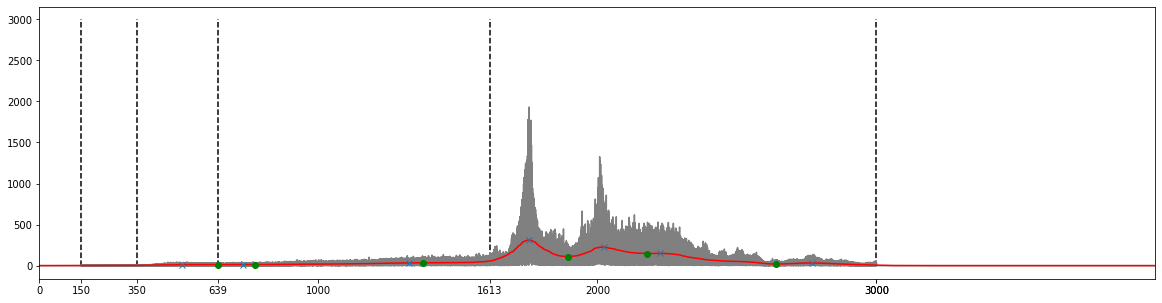

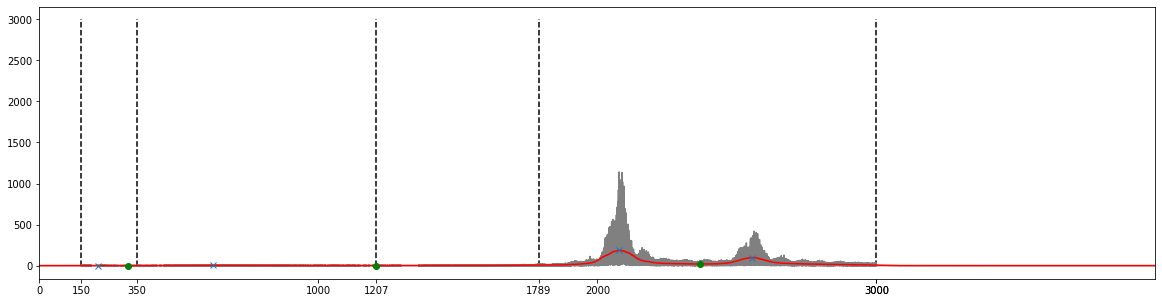

In [ ]:
male_female_call_separation('/content/01-F818D-F8387-220616_0456_8min_selection (1).wav','01-F818D-F8387-220616_0456_8min_selection (1)')
male_female_call_separation('/content/02-F8212-F829D-220617_0244_2min_selection.wav','02-F8212-F829D-220617_0244_2min_selection')